In [1]:
import random
import os
import sys
import warnings
import datetime

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

#TensorFlow libraries
#TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, models, losses

from tqdm import tqdm
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())



TensorFlow Version: 2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [1]:
from tensorflow_estimator.python.estimator.api._v2 import estimator as estimator
from keras.api._v2 import keras
from keras.api._v2.keras import losses
from keras.api._v2.keras import models
from keras.api._v2.keras import layers
from keras.api._v2.keras import callbacks
from keras.layers import concatenate, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, Activation, MaxPooling2D
from keras.models import Model, load_model



#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, start_neurons):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, start_neurons * 1) 
    s2, p2 = encoder_block(p1, start_neurons * 2)

    b1 = conv_block(p2, start_neurons * 16)

    d2 = decoder_block(b1, s2, start_neurons * 2)
    d1 = decoder_block(d2, s1, start_neurons * 1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model
input_shape = (512,512,1)
model = build_unet(input_shape, 32)
#model.compile(loss = FreqLoss, optimizer="adam", metrics=["mean_squared_error"],)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [3]:
'''## Parameters used in gathers:
Ntrainingsamples = 1      # Number of gathers windowed to generate training examples[-]
Ntestsamples = 1           # Number of test examples for the network to interpolate
dt = 0.004                 # Sampling rate [s]
Fs = 1/dt                  # Sampling frequency (500 Hz)
noiselevel = 0.1           # Percent noise 
RandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges
TracesPerGather = 635      # Number of traces in each gather. Default for NoSI_short is 636.

#Lower boundary of filter
flp = 20 


#Windowing Parameters:
input_width = 64         # Columns in window (space)
input_height = 157      # Rows in window (time)
overlap = 0.5            # Ratio of overlap

start_time = 0           # Where to start reading each gather incase you wish to cut off some samples
end_time = 1256       # Where to stop reading each gather. Use '-1' to select the last sample


#Network parameters
dropout = 0.0
BatchSize = 4
ValidationSplit = 0.2
Epochs = 20

'''

"## Parameters used in gathers:\nNtrainingsamples = 1      # Number of gathers windowed to generate training examples[-]\nNtestsamples = 1           # Number of test examples for the network to interpolate\ndt = 0.004                 # Sampling rate [s]\nFs = 1/dt                  # Sampling frequency (500 Hz)\nnoiselevel = 0.1           # Percent noise \nRandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges\nTracesPerGather = 635      # Number of traces in each gather. Default for NoSI_short is 636.\n\n#Lower boundary of filter\nflp = 20 \n\n\n#Windowing Parameters:\ninput_width = 64         # Columns in window (space)\ninput_height = 157      # Rows in window (time)\noverlap = 0.5            # Ratio of overlap\n\nstart_time = 0           # Where to start reading each gather incase you wish to cut off some samples\nend_time = 1256       # Where to stop reading each gather. Use '-1' to select the last sample\n\n\n#Network parameters\ndropout = 0.0\nBatchSize = 

(5120, 1023)


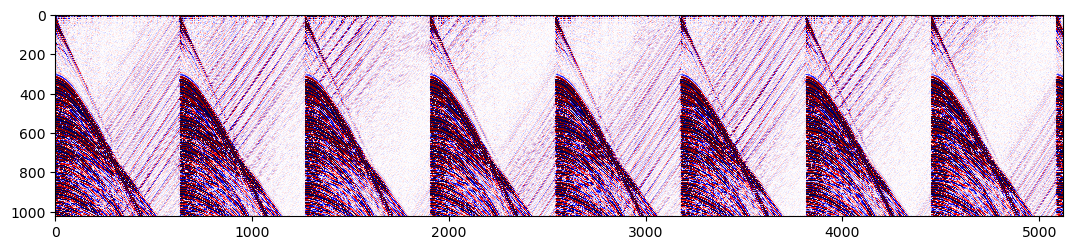

In [2]:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Sam - Github/Neural Network/' 
filename = 'IRP1909132tlaa.P_s1_c5_LC.sgy'

TPG = 512   ## for the sake of simplicity 
start_time = 0
end_time = 1023
with segyio.open(path + filename, ignore_geometry=True) as f:
    gather = f.trace.raw[:]
    gather= gather[0:TPG*10,start_time:end_time]
    print(gather.shape)
    plt.figure(figsize=(13,8))
    plt.imshow(gather.T,cmap='seismic',vmax=100,vmin=-100)
    


In [43]:
## Defining Matrices: 8 training set and 2 test set 
# Gather Window size (M*N) and RFFT window size (M/2*N)
'''TPG = 635 # Trace Per Gather
ini_time = 0 # Initial time for the gather
end_time = 1600 # End time for the gather'''
end_freq = int ((end_time/2)+1)
# Training and Test Gather Size
NN_training = 8
NN_test = 2
NN_windows = 32 # Num of windows in a gather

Filt_train = np.zeros((36,256,64))
Rfft_train = np.zeros((36,129,64))
Filt_rfft_train = np.zeros((36,129,64))


#Rfft_train = np.zeros((NN_training*1,end_freq,TPG,1))
#Filt_rfft_train = np.zeros((NN_training*1,end_freq,TPG,1))
#irfft_train = np.zeros((8*1,1600,635))


#Filt_test = np.zeros((NN_test*1,end_time,TPG,1))
Rfft_test = np.zeros((NN_test*1,end_freq,TPG,1))
Filt_rfft_test = np.zeros((NN_test*1,end_freq,TPG,1))
#irfft_test = np.zeros((2*1,1600,635))

Freq_Train = np.zeros((9,1))
Freq_Test = np.zeros((1,1))

print(Filt_train.shape)



(36, 256, 64)


In [56]:
## Sliding window to store training and test data - One gather at a time (1600*636) with no over lap 
# Here, a windoe size of one gather is moved over 10 gather and storing the rfft and irfft gather
trigger = False
flp=40
fhi=100
counter=0
dt = 0.004
(f._samples,f._xlines) = butter(5,[flp/250,fhi/250],'stop')
list =[]
## Training Set
counter = 0
#for k in tqdm (np.arange(NN_training)):
for i in range (0,1025,256):
    g_s = i
    g_e = i+256
    for j in range (0,513,64):
        t_s=j
        t_e = j+64
        window = gather[t_s:t_e,g_s:g_e]
        if np.any(window) == True:
            filtered_train =  filtfilt(f._samples,f._xlines,window)
            rfft_train =np.abs(np.fft.rfft2(window))
            filt_rfft_train = np.abs(np.fft.rfft2(filtered_train))
            #filt_irfft_train = np.abs(np.fft.irfft2(window_rfft))
            list.append(filtered_train)
            if window.shape[1] == 255:
                window=gather[t_s:t_e,g_s-1:g_e]
                filtered_train =  filtfilt(f._samples,f._xlines,window)
                rfft_train = np.abs(np.fft.rfft2(window))
                filt_rfft_train = np.abs(np.fft.rfft2(filtered_train))
                Filt_train[counter] = filtered_train.T 
                Rfft_train[counter] = rfft_train.T 
                Filt_rfft_train[counter] = filt_rfft_train.T
                
            counter +=1 
            
    
''''## Test Set 
for k in tqdm (np.arange(NN_test)):
    for i in range (512*8,5120,512):
        t_s = i
        t_e = i+512
        window = gather[t_s:t_e,start_time:end_time]
        if trigger == False and np.any(window) == True:
            filtered_test =  filtfilt(f._samples,f._xlines,window)
            rfft_test =np.abs(np.fft.rfft2(window))
            filt_rfft_test = np.abs(np.fft.rfft2(filtered_test))
            #filt_irfft_train = np.fft.irfft2(window_rfft)

            #Filt_test[counter] = filtered_test.reshape(end_time,TPG,1)
            Rfft_test[k] = rfft_test.reshape(end_freq,TPG,1)  
            Filt_rfft_test[k] = filt_rfft_test.reshape(end_freq,TPG,1)
            
        break'''
print('Done!')
print(f'There are {Rfft_train.shape[0]} training samples.')
print(f'There are {Rfft_test.shape[0]} test samples.')


Done!
There are 36 training samples.
There are 2 test samples.


In [62]:
print(Rfft_train.shape)
data = np.concatenate(Rfft_train)
data.shape
data = np.array(list)


(36, 129, 64)


C:\Users\Ssach\AppData\Local\Temp\ipykernel_11440\396030375.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(list)


ValueError: could not broadcast input array from shape (64,256) into shape (64,)

### Build Neural Network

In [6]:
## Defining Convlution Block, Bridge and Deconvolution block
'''num_filters=32
def conv_block(inputs,num_filters,batch_norm=False,dropout_prob=0):

    conv1 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inputs)
    conv2 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(conv1)
    if batch_norm:
        conv1= BatchNormalization(axis=-1)(conv1)
    conv1 = ReLU(alpha=0.2)(conv1)

    conv2 = Conv2D(n_filters,3,padding='same')(conv1)
    if batch_norm:
        conv2= BatchNormalization(axis=-1)(conv2)
    conv2 = ReLU(alpha=0.2)(conv1)

    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)

    return conv2

def encoder_block(inputs,num_filter,batch_norm=False,dropout_prob=0):

    skip_conncetion = conv_block(inputs,num_filters)
    next_layer = MaxPooling2D((2,2))(skip_conncetion)

    return next_layer,skip_conncetion

def decoder_block(inputs,skip_connection,num_filters,batch_norm = False, dropout_prob=0):

    up = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inputs)
    merge = Concatenate()([up, skip_connection])
    conv = conv_block(merge, num_filters)

    return conv

def unet_model(input_size = (512,64,1), n_filters=64,n_classes=5, batch_norm = True, dropout=np.zeros(9)):
    inputs = Input(input_size)
    ### Encoder
    enc_1 = encoder_block(inputs,n_filters,batch_norm,dropout_prob=dropout[0])
    enc_2 = encoder_block(enc_1[0],n_filters*2,batch_norm,dropout_prob=dropout[1])
    enc_3 = encoder_block(enc_2[0],n_filters*4,batch_norm,dropout_prob=dropout[2])
    enc_4 = encoder_block(enc_3[0],n_filters*8,batch_norm,dropout_prob=dropout[3])

    ## Bridge 
    bridge = conv_block(enc_4[0],n_filters*16,batch_norm,dropout_prob=dropout[4])

    ## Decoder
    dec_4 = decoder_block(bridge,enc_4[1],n_filters*8,batch_norm,dropout_prob=dropout[5])
    dec_3 = decoder_block(dec_4,enc_3[1],n_filters*4,batch_norm,dropout_prob=dropout[6])
    dec_2 = decoder_block(dec_3,enc_2[1],n_filters*2,batch_norm,dropout_prob=dropout[7])
    dec_1 = decoder_block(dec_2,enc_1[1],n_filters*1,batch_norm,dropout_prob=dropout[8])

    if n_classes == 2:
        conv10 = Conv2D(1,1,padding ='same')(dec_1)
        output = Activation('sigmoid')(conv10)

    else: 
        conv10 = Conv2D(n_classes,1,padding ='same')(dec_1)
        output = Activation('softmax')(conv10)

    model = tf.keras.Model(inputs = inputs, outputs = output, name='Unet')

    return model'''




'num_filters=32\ndef conv_block(inputs,num_filters,batch_norm=False,dropout_prob=0):\n\n    conv1 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer=\'HeNormal\')(inputs)\n    conv2 = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer=\'HeNormal\')(conv1)\n    if batch_norm:\n        conv1= BatchNormalization(axis=-1)(conv1)\n    conv1 = ReLU(alpha=0.2)(conv1)\n\n    conv2 = Conv2D(n_filters,3,padding=\'same\')(conv1)\n    if batch_norm:\n        conv2= BatchNormalization(axis=-1)(conv2)\n    conv2 = ReLU(alpha=0.2)(conv1)\n\n    if dropout_prob > 0:\n        conv2 = Dropout(dropout_prob)(conv2)\n\n    return conv2\n\ndef encoder_block(inputs,num_filter,batch_norm=False,dropout_prob=0):\n\n    skip_conncetion = conv_block(inputs,num_filters)\n    next_layer = MaxPooling2D((2,2))(skip_conncetion)\n\n    return next_layer,skip_conncetion\n\ndef decoder_block(inputs,skip_connection,num_filters,batch_norm = False, dropout_prob=0):

In [5]:
Ntrainingsamples = 9    # Number of gathers windowed to generate training examples[-]
Ntestsamples = 1       # Number of test examples for the network to interpolate
dt = 0.004                 # Sampling rate [s]
Fs = 1/dt                  # Sampling frequency (500 Hz)
noiselevel = 0.1           # Percent noise 
RandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges
TracesPerGather = 512      # Number of traces in each gather. Default for NoSI_short is 636.

#Lower boundary of filter
flp = 20 


#Windowing Parameters:
input_width = 512        # Columns in window (space)
input_height = 512       # Rows in window (time)
overlap = 0.5            # Ratio of overlap

start_time = 0           # Where to start reading each gather incase you wish to cut off some samples
end_time = 1024          # Where to stop reading each gather. Use '-1' to select the last sample


#Network parameters
dropout = 0.0
BatchSize = 4
ValidationSplit = 0.2
Epochs = 20



In [6]:
#Filters to remove the 'missing' from the broadband data:

#Band-stop filter to remove the missing band
def myFilterStop(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandstop',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Band-pass filter to remove all but the missing frequency band. This was used to test the networks perforance on reconstructing
#missing frequencty data.
def myFilterPass(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandpass',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

#Zeroing strong filter
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp/2
    fhi = fhi/2
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = fft(data,axis=0)
    Filter = np.ones(Data_Freq.shape)
    Filter[int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])),:] = 0
    Filter[-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0])),:] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt,axis=0))


#Two custom loss functions:

#This loss function looks into the spatially similarity of the gather.
def MyLoss(y_true, y_pred):
    
    #Compute Huber loss
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Compute structural similarity index
    SSIM = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    return   1 - SSIM + L1


#Frequency loss function that takes the frequency data into account. 
def FreqLoss(y_true, y_pred):
    
    #Create Huber loss function
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Cast in- and output data in complex for to perform fft
    y_true_f = tf.dtypes.cast(y_true, tf.complex64)
    y_pred_f = tf.dtypes.cast(y_pred, tf.complex64)
    
    #Compute fft
    y_true_fft = tf.signal.fft3d(y_true_f)
    y_pred_fft = tf.signal.fft3d(y_pred_f)
    
    #Compute MAE of frequency domain data
    FreqRMS = tf.math.reduce_mean(tf.abs(y_true_fft-y_pred_fft))
    
    return FreqRMS + L1


#Defining necessary layers for the neural network

#Coordinate Attention block. Taken from: https://github.com/Andrew-Qibin/CoordAttention
#This function is unused in the actual network unless uncommented
def CoordAtt(x, reduction=32, bn_trainable=False):
    def coord_act(x):
        tmpx = (ReLU(max_value=6)(x + 3)) / 6
        x = x * tmpx
        return x

    x_shape = x.shape.as_list()
    [b, h, w, c] = x_shape
    
    x_h = AveragePooling2D(pool_size=(1, w), strides=(1, 1), data_format='channels_last')(x)
    x_w = AveragePooling2D(pool_size=(h, 1), strides=(1, 1), data_format='channels_last')(x)
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    y = concatenate(inputs=[x_h, x_w], axis=1)
    
    mip = max(8, c // reduction)
    
    y = Conv2D(filters=mip, kernel_size=(1, 1), strides=(1, 1), padding='valid')(y)
    y = BatchNormalization(trainable=bn_trainable)(y)
    y = coord_act(y)
    
    x_h, x_w = Lambda(tf.split, arguments={'axis': 1, 'num_or_size_splits': [h, w]})(y)
    
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    a_h = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_h)
    a_w = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_w)
    
    out = x * a_h * a_w
    
    return out


#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



In [9]:
# Get and resize train images and masks
# Number of layers is num. gather * num. windows per gather

#Read the SEGY with segyio and split into gathers
counter = 0

#Define ouput windows
output_width = np.round(overlap*input_width) 
output_height = np.round(overlap*input_height)
        
#Open the segy data files.
with segyio.open(path + filename, ignore_geometry=True) as f:
    
     #============================= GENERATE TRAINING DATA =====================================
        
    print('Getting training images ... ')
    NumWindows = int(np.floor(TracesPerGather/output_width)*np.floor(len(f.samples)/output_height))
    
    #Define matrices to be filledin
    X_train = np.zeros((Ntrainingsamples * NumWindows*4, input_height, input_width, 1))
    Y_train = np.zeros((Ntrainingsamples * NumWindows*4, input_height, input_width, 1))
    
    X_test = np.zeros((Ntestsamples * NumWindows*4, input_height, input_width, 1))
    Y_test = np.zeros((Ntestsamples * NumWindows*4, input_height, input_width, 1))
    
    #Frequencies to be removed, note that this number should be changed in case the number/type of filters change
    freqRemoveTrain = np.zeros((Ntrainingsamples * NumWindows*4,4))
    freqRemoveTest = np.zeros((Ntestsamples * NumWindows*4,4))
    
    for k in tqdm(np.arange(Ntrainingsamples)):
        
        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather) : k+(k+1)*(TracesPerGather)]
        
        
#         #Adding a gain:
#         t = np.arange(0,endtime*dt,dt)**1.4
#         t2gain = np.repeat(t,numberoftraces).reshape(endtime,numberoftraces)
#         gather = gather*t2gain
        
        
        #Filter out frequencies
        freqRemoveTrain[k,0] = flp;
        freqRemoveTrain[k,1] = freqRemoveTrain[k,0] + 5;

        gatherfilt = myStrongFilter(gather,freqRemoveTrain[k,0],freqRemoveTrain[k,1],dt);
        
        #Add noise
        np.random.seed(k+1)
        sample = noiselevel*norm.ppf(np.random.rand(gatherfilt.shape[0], gatherfilt.shape[1]))
        gatherfilt = gatherfilt + sample
        
        #Apply windowing to gather (My appolgies for making it hard to read, but it's faster than having if/else)
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]


                
                #Fill window into training matrix
                X_train[counter] = input_windowfilt.reshape(input_height,input_width,1)
                Y_train[counter] = input_window.reshape(input_height,input_width,1)
    
    
                #Add to counter
                counter += 1
            
    #============================= GENERATE TEST DATA =====================================
    
    print('Getting test images ... ')
    counter = 0
    
    #The remaining samples (or number of gathers selected) of the dataset will be used as test data. 
    for k in tqdm(np.arange(Ntrainingsamples, Ntrainingsamples + Ntestsamples)):

#     k=199 #Use this instead of the above for-loop to only create one gather and compare to the sparse solver 

        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather) : k+(k+1)*(TracesPerGather)]
        print(gather.shape)
        #Filter out frequencies
        freqRemoveTest[k,0] = flp;
        freqRemoveTest[k,1] = freqRemoveTest[k,0] + 5;

        gatherfilt = myStrongFilter(gather,freqRemoveTest[k,0],freqRemoveTest[k,1],dt);

        #Add noise
        np.random.seed(k+1)
        sample = noiselevel*norm.ppf(np.random.rand(gatherfilt.shape[0], gatherfilt.shape[1]))
        gatherfilt = gatherfilt + sample

        #Apply windowing to gather
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]

                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]

    #                 #Add noise
    #                 input_windowfilt = input_windowfilt + noiselevel * np.random.normal(input_height,input_width)


                #Fill window into training matrix
                X_test[counter] = input_windowfilt.reshape(input_height,input_width,1)
                Y_test[counter] = input_window.reshape(input_height,input_width,1)


                #Add to counter
                counter += 1    
        f.close()

print('Deleting empty arrays ...')
#The following lines look for any arrays that are all zeros and deletes them.
freqRemoveTrain = freqRemoveTrain[~np.all(X_train == 0, axis=(1,2,3))]
freqRemoveTest = freqRemoveTest[~np.all(X_test == 0, axis=(1,2,3))]
X_train = X_train[~np.all(X_train == 0, axis=(1,2,3))]
X_test = X_test[~np.all(Y_test == 0, axis=(1,2,3))]
Y_train = Y_train[~np.all(Y_train == 0, axis=(1,2,3))]
Y_test = Y_test[~np.all(Y_test == 0, axis=(1,2,3))]


print('Deleting duplicate arrays from training data ...')
#REMOVE DUPLICATES
_, b = np.unique(Y_train, return_index = 1 ,axis=0)
X_train = X_train[np.sort(b)] 
Y_train = Y_train[np.sort(b)]

# print('Deleting arrays with insignificant SNR ...')
# #The following windows contain only noisy event prior to the first arrivals.
# #I need to come up with a better way of removing these (more robust)
# indexes = np.concatenate([np.arange(0,9,1),np.arange(20,32,1),np.arange(40,57,1),np.arange(60,80,1)])
# indexes = np.repeat(indexes, Ntrainingsamples, axis=0).reshape((int(indexes.shape[0]),Ntrainingsamples))
# scalers = np.arange(0,(Ntrainingsamples)*80,80)
# scalers = np.matlib.repmat(scalers,int(indexes.shape[0]),1)
# ind2keep = indexes+scalers
# X_train = X_train[ind2keep.T.flatten()]
# Y_train = Y_train[ind2keep.T.flatten()]

# del indexes
# del scalers
# del ind2keep

print('Normalizing ...')
#Normalization:
normfac = np.max(np.array([
                              np.max(np.abs(X_train)), 
                              np.max(np.abs(Y_train)),
                              np.max(np.abs(X_test)), 
                              np.max(np.abs(Y_test))]))
X_train = ((X_train / normfac) + 1) / 2
Y_train = ((Y_train / normfac) + 1) / 2
X_test = ((X_test / normfac) + 1) / 2
Y_test = ((Y_test / normfac) + 1) / 2

#Deleting unnecessary variables to save memory
del gather
del _
del b

print('Done!')
print(f'There are {X_train.shape[0]} training samples.')
print(f'There are {X_test.shape[0]} test samples.')

Getting training images ... 


100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


Getting test images ... 


  0%|          | 0/1 [00:00<?, ?it/s]

(1024, 512)


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Deleting empty arrays ...


Deleting duplicate arrays from training data ...
Normalizing ...
Done!
There are 36 training samples.
There are 8 test samples.


In [8]:
print(gather)
plt.imshow(X_train[34])

NameError: name 'gather' is not defined

In [22]:
from tensorflow_estimator.python.estimator.api._v2 import estimator as estimator
from keras.api._v2 import keras
from keras.api._v2.keras import losses
from keras.api._v2.keras import models
from keras.api._v2.keras import layers
from keras.api._v2.keras import callbacks
from keras.layers import concatenate, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, Activation, MaxPooling2D
from keras.models import Model, load_model



#Convolution block
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

#Encoding block
def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

#Decoding block
def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, start_neurons):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, start_neurons * 1) 
    s2, p2 = encoder_block(p1, start_neurons * 2)

    b1 = conv_block(p2, start_neurons * 16)

    d2 = decoder_block(b1, s2, start_neurons * 2)
    d1 = decoder_block(d2, s1, start_neurons * 1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model
input_shape = (512,512,1)
model = build_unet(input_shape, 32)
#model.compile(loss = FreqLoss, optimizer="adam", metrics=["mean_squared_error"],)
model.summary()

: 

: 